# Improving quantization by normalizing weights

> "While trying to implement the previous post about quantization I faced some difficulties. So it is better to write them down for everyone to know (including a future me). Also, I think the process of solving these issues may apply to other problems. Without further do, time to fix🔨!"

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [quantization, efficient_deeplearning]
- image: images/detective.png

![](https://raw.githubusercontent.com/XanaGA/posts_en/6d6f32ecc94946e193b900fbe0f0f6c99cfcf14c/images/detective.png)

# Introduction

I have hidden all the code from the previous [post](https://xanaga.github.io/posts_en/quantization/efficient_deeplearning/2022/05/29/Quantizing_A_Deep_Learning_Model_PyTorch.html) so we can focus on the experiments but you can find it if you download the notebook or open it in colab.

# Collecting the Dataset

In [ ]:
# hide

import numpy as np
import time
import os
import torch
import torchvision
from torch import nn, optim
from torchsummary import summary
from tqdm.notebook import tqdm
import torch.utils.data as data_utils

def process_x(x):
  """Process the given tensors of images."""
  x = x.type(torch.float32) 

  # The original data is in [0.0, 255.0].
  # This normalization helps in making them lie between [-1.0, 1.0].
  x /= 127.5
  x -= 1.0

  # Add one dimension for the channels 
  # We add it to dim 1 because Pytorch image format is [CxWxH]
  x = torch.unsqueeze(x, dim=1)
  return x

def load_data(ds=torchvision.datasets.MNIST):
  """Returns the processed dataset."""
  training, test = ds('/data/mnist', download=True), ds('/data/mnist', download=True, train=False)
  train_images, train_labels = process_x(training.data), training.targets
  test_images, test_labels = process_x(test.data), test.targets
  
  return (train_images, train_labels), (test_images, test_labels)


(train_x, train_y), (test_x, test_y) = load_data()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



In [ ]:
# hide

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Visualize the dataset

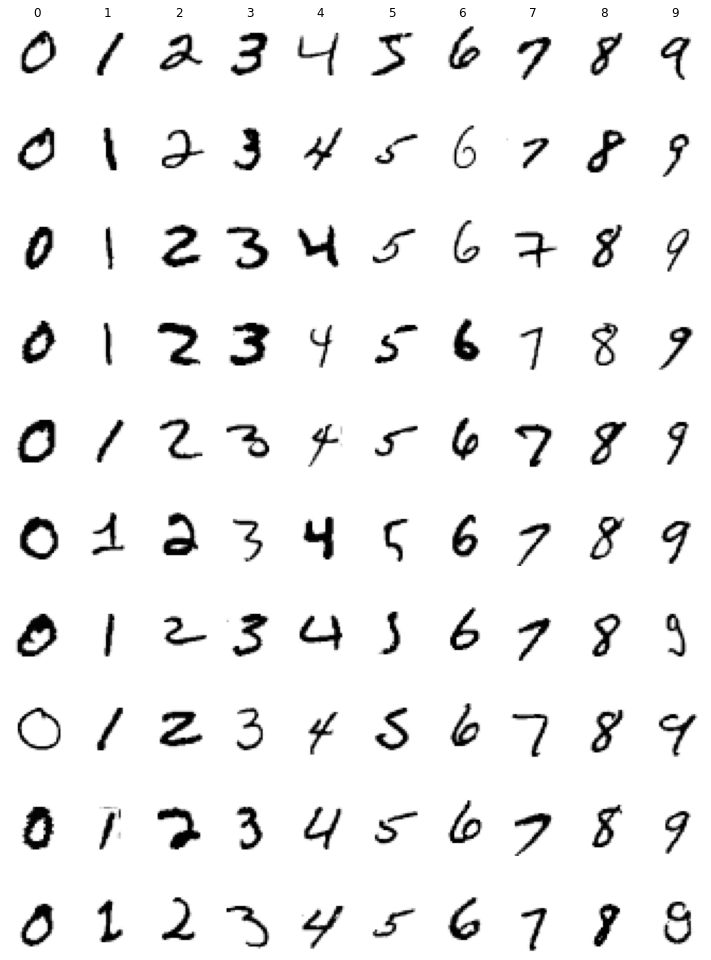

In [ ]:
# hide

%matplotlib inline
import matplotlib.pyplot as plt

def collect_samples(x, y, num_classes=10, num_per_class=5):
  sampled_x = None
  sampled_x_idx = 0
  for class_idx in range(num_classes):
    num_collected = 0
    for idx in range(len(x)):
      if num_collected == num_per_class:
        break

      if y[idx] != class_idx:
        continue

      if sampled_x is not None:
        sampled_x = np.concatenate((sampled_x, np.expand_dims(x[idx], 0)))
      else:
        sampled_x = np.expand_dims(x[idx], 0)
      sampled_x_idx = sampled_x_idx + 1
      num_collected = num_collected + 1

  return sampled_x

def show_images(images, num_rows = 1, titles = None):
    """Display a list of images in a single figure with matplotlib. """
    # assert((titles is None)or (len(images) == len(titles)))
    num_images = len(images)
    num_cols = num_images // num_rows

    # plot images
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.25 * num_rows, 1.75 * num_cols))
    
    for i in range(num_images):
      ax = axes[i%num_cols, i//num_cols]
      ax.axis('off')
      ax.imshow(np.squeeze(images[i]), cmap='Greys')
      # ax.add_axes((0, 0, 1, 1))
      if i % num_cols == 0:
        ax.set_title('{}'.format(int(i / num_rows)))
    # plt.tight_layout()
    plt.show()
  
show_images(collect_samples(train_x, train_y, num_per_class=10), num_rows=10)

Remember the model class definition.

In [ ]:
class CNN(nn.Module):
    def __init__(self, dropout_rate=0.0, norm_w=True):
        super(CNN, self).__init__()

        self.norm_w = norm_w

        # Create the layers normalizing or not the weigths
        if self.norm_w:
            self.conv_layer1 = nn.utils.weight_norm(nn.Conv2d(in_channels=1, out_channels=32, 
                                     kernel_size=3), name='weight')
            self.conv_layer2 = nn.utils.weight_norm(nn.Conv2d(32, 64, 3), name='weight')
            self.fc = nn.utils.weight_norm(nn.Linear(in_features= 64*5*5, out_features=10), name='weight')
          
        else:
            self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=32, 
                                     kernel_size=3)
            self.conv_layer2 = nn.Conv2d(32, 64, 3)
            self.fc = nn.Linear(in_features= 64*5*5, out_features=10)

        
        # input dimensions are Bx1x28x28 (BxCxHxW)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.batch_norm2 = nn.BatchNorm2d(64)

        self.flat = nn.Flatten()
        self.drop = nn.Dropout(p=dropout_rate)


    def forward(self, x):
        # Block 1
        out = self.conv_layer1(x)
        out = self.batch_norm1(out)
        out = self.relu(out)
        out = self.pool(out)

        # Block 2
        out = self.conv_layer2(out)
        out = self.batch_norm2(out)
        out = self.relu(out)
        out = self.pool(out)

        # Flatten the output using BxC*H*W 
        out = self.flat(out)
        out = self.drop(out)
        out = self.fc(out)
        
        return out

    def add_quant(self):
        '''
        Returns a new model with added quantization layers
        '''
        return nn.Sequential(torch.quantization.QuantStub(), self,
                          torch.quantization.DeQuantStub())

In [ ]:
# hide

# Check the model 
toy_model = CNN()
summary(toy_model, input_size=(1,28,28),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
              ReLU-3           [-1, 32, 26, 26]               0
         MaxPool2d-4           [-1, 32, 13, 13]               0
            Conv2d-5           [-1, 64, 11, 11]          18,496
       BatchNorm2d-6           [-1, 64, 11, 11]             128
              ReLU-7           [-1, 64, 11, 11]               0
         MaxPool2d-8             [-1, 64, 5, 5]               0
           Flatten-9                 [-1, 1600]               0
          Dropout-10                 [-1, 1600]               0
           Linear-11                   [-1, 10]          16,010
Total params: 35,018
Trainable params: 35,018
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Training without PyTorch Model Quantization

In [ ]:
# hide

def train_model(model, epochs, bz=128, device='cuda'):
  # Save the model training information
  model_history = {"loss":[], "sparse_categorical_accuracy": [],
                   "val_loss":[], "val_sparse_categorical_accuracy":[]}

  # Show the model summary
  model.to(device)
  summary(model, input_size=(1,28,28), device=device)

  # Define the training hyperparameters
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  criterion = nn.CrossEntropyLoss()

  # Create the training and validation dataloders
  train = data_utils.TensorDataset(train_x, train_y)
  train_loader = data_utils.DataLoader(train, batch_size=bz, shuffle=True)

  val = data_utils.TensorDataset(test_x, test_y)
  val_loader = data_utils.DataLoader(val, batch_size=bz, shuffle=False)

  for epoch in range(epochs):  # loop over the number of epochs

    start = time.time()
    print(f'Epoch {epoch+1}')
    train_loss = 0.0
    train_correct = 0.0

    val_loss = 0.0
    val_correct = 0.0

    # Loop over the trainig set
    for data in tqdm(train_loader):

        # Move the data to the corresponding device
        x, y = data
        x, y = x.to(device), y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += outputs.shape[0] * loss.item()
        train_correct += (outputs.argmax(1) == y).detach().cpu().sum()
    
    # Log the training loss and metrics
    train_loss = train_loss/float(len(train_x))
    train_correct = train_correct/float(len(train_x))

    model_history["loss"].append(train_loss)
    model_history["sparse_categorical_accuracy"].append(train_correct)

    #Loop over the validation set:
    model.eval()
    with torch.inference_mode():

      for data in val_loader:
          x, y = data
          x, y = x.to(device), y.to(device)

          outputs = model(x)
          loss = criterion(outputs, y)

          val_loss += outputs.shape[0] * loss.item()
          val_correct += (outputs.argmax(1) == y).detach().cpu().sum()

    # Log the training loss and metrics
    val_loss = val_loss/float(len(test_x))
    val_correct = val_correct/float(len(test_x))

    model_history["val_loss"].append(val_loss)
    model_history["val_sparse_categorical_accuracy"].append(val_correct)

    model.train()

    end = time.time()

    # Print information for the epoch
    print(f"Time: {(end-start):.2f} s  - ",
          f"Loss: {train_loss:.4f}  -  Categorical_Accuracy: {train_correct:.4f}  - ",
          f"Val_Loss: {val_loss:.4f}  -  Categorical_Val_Accuracy: {val_correct:.4f}")

  print('Finished Training')

  return model, model_history

# Helper functions for Pytorch Quantizantion and evaluation

In [ ]:
# hide

def model_size(model):
  param_size = 0
  for param in model.parameters():
      param_size += param.nelement() * param.element_size()
      
  buffer_size = 0
  for buffer in model.buffers():
      buffer_size += buffer.nelement() * buffer.element_size()

  model_size = (param_size + buffer_size) / 1024

def real_model_size(model):
  torch.save(model.state_dict(), "temp.p")
  size = os.path.getsize("temp.p")/1024
  os.remove('temp.p')
  return size

In [ ]:
# hide

def pytorch_model_eval(model, test_images, test_labels, quantized):
  """Evaluate the generated model."""

  num_correct = 0
  num_total = 0

  model.eval()

  with torch.inference_mode():
    for idx in range(len(test_images)):
      num_total = num_total + 1

      if quantized:
          input = test_images[idx:idx+1].to("cpu")
      else:
          input = test_images[idx:idx+1].to(device)
          
      
      output = model(input)

      # The returned output is a tensor of logits, so we find the maximum in that 
      # tensor, and see if it matches the label.
      if output.argmax(1) == test_labels[idx]:
        num_correct = num_correct + 1
  
  print('Accuracy:', num_correct * 1.0 / num_total)

In [ ]:
#hide

# Create the directory for storing PyTorch models.
! mkdir -p 'pytorch_models'

def quantize_and_eval(model, model_name, quantized_export, test_dataset_x, 
                     test_dataset_y):
  """Helper method to eval a model (quantizing it or not)."""

  # Remove the normalization from the weighted layers
  if model.norm_w:
    for m in model.modules():
      if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.utils.remove_weight_norm(m)

  if quantized_export:
    
    # Some operations not suported on GPU
    model.to("cpu")

    # Backend for using a serever
    backend = "fbgemm"

    """Fuse
    - Inplace fusion replaces the first module in the sequence with the fused module, and the rest with identity modules
    """
    model.eval()
    torch.quantization.fuse_modules(model, [['conv_layer1','batch_norm1','relu'], 
                                            ['conv_layer2', 'batch_norm2']], inplace=True)

    """Insert stubs"""
    model = model.add_quant()

    """Prepare"""
    model.qconfig = torch.quantization.get_default_qconfig(backend)
    torch.quantization.prepare(model, inplace=True)

    """Calibrate"""
    with torch.inference_mode():
      for idx in range(min(len(test_dataset_x), 1000)):
        x = test_dataset_x[idx:idx+1].to("cpu")
        model(x)
        
    """Convert"""
    torch.quantization.convert(model, inplace=True)

  model_name = '{}_{}.pt'.format(
      model_name, ('quantized' if quantized_export else 'float'))
  
  print('Model Name: {}, Quantized: {}'.format(model_name, quantized_export))
  print('Model Size: {:.2f} KB'.format(real_model_size(model)))
  torch.save(model.state_dict(), os.path.join('pytorch_models', model_name))
  
  # Evaluate the model.
  start = time.time()
  pytorch_model_eval(model, test_dataset_x, test_dataset_y, 
                    quantized_export)
  end = time.time()
  print('Eval time: {:.2f}s'.format(end-start))

# Chain everything together in a single train function

In [ ]:
#hide

import os
import numpy as np
from copy import deepcopy

def train_model_and_quantize(batch_size=128, epochs=100, model_name='mnist_model', norm_w=True):
  model = CNN(norm_w=norm_w).to(device)

  model, model_history = train_model(model, epochs, bz=batch_size)

  print("Running Final Evaluation")

  # Convert and evaluate both (floating point and quantized models).
  q_model = deepcopy(model)
  quantize_and_eval(model, model_name, False, test_x, test_y)
  quantize_and_eval(q_model, model_name, True, test_x, test_y)

  return model, model_history

# Experiments

Let's simulate that it is our first time facing this problem, so we haven't thought about normalizing the weights.

In [ ]:
model_15, _ = train_model_and_quantize(epochs=15, norm_w=False)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
              ReLU-3           [-1, 32, 26, 26]               0
         MaxPool2d-4           [-1, 32, 13, 13]               0
            Conv2d-5           [-1, 64, 11, 11]          18,496
       BatchNorm2d-6           [-1, 64, 11, 11]             128
              ReLU-7           [-1, 64, 11, 11]               0
         MaxPool2d-8             [-1, 64, 5, 5]               0
           Flatten-9                 [-1, 1600]               0
          Dropout-10                 [-1, 1600]               0
           Linear-11                   [-1, 10]          16,010
Total params: 35,018
Trainable params: 35,018
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.53 s  -  Loss: 0.2702  -  Categorical_Accuracy: 0.9447  -  Val_Loss: 0.0466  -  Categorical_Val_Accuracy: 0.9848
Epoch 2


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.21 s  -  Loss: 0.0523  -  Categorical_Accuracy: 0.9837  -  Val_Loss: 0.0416  -  Categorical_Val_Accuracy: 0.9869
Epoch 3


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.21 s  -  Loss: 0.0358  -  Categorical_Accuracy: 0.9885  -  Val_Loss: 0.0286  -  Categorical_Val_Accuracy: 0.9904
Epoch 4


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.20 s  -  Loss: 0.0291  -  Categorical_Accuracy: 0.9907  -  Val_Loss: 0.0337  -  Categorical_Val_Accuracy: 0.9888
Epoch 5


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.20 s  -  Loss: 0.0250  -  Categorical_Accuracy: 0.9920  -  Val_Loss: 0.0335  -  Categorical_Val_Accuracy: 0.9909
Epoch 6


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.22 s  -  Loss: 0.0204  -  Categorical_Accuracy: 0.9937  -  Val_Loss: 0.0306  -  Categorical_Val_Accuracy: 0.9898
Epoch 7


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.26 s  -  Loss: 0.0183  -  Categorical_Accuracy: 0.9945  -  Val_Loss: 0.0419  -  Categorical_Val_Accuracy: 0.9863
Epoch 8


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.23 s  -  Loss: 0.0168  -  Categorical_Accuracy: 0.9946  -  Val_Loss: 0.0379  -  Categorical_Val_Accuracy: 0.9900
Epoch 9


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.23 s  -  Loss: 0.0176  -  Categorical_Accuracy: 0.9941  -  Val_Loss: 0.0436  -  Categorical_Val_Accuracy: 0.9882
Epoch 10


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.23 s  -  Loss: 0.0159  -  Categorical_Accuracy: 0.9945  -  Val_Loss: 0.0376  -  Categorical_Val_Accuracy: 0.9889
Epoch 11


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.21 s  -  Loss: 0.0159  -  Categorical_Accuracy: 0.9949  -  Val_Loss: 0.0433  -  Categorical_Val_Accuracy: 0.9881
Epoch 12


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.21 s  -  Loss: 0.0132  -  Categorical_Accuracy: 0.9954  -  Val_Loss: 0.0428  -  Categorical_Val_Accuracy: 0.9894
Epoch 13


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.21 s  -  Loss: 0.0143  -  Categorical_Accuracy: 0.9956  -  Val_Loss: 0.0443  -  Categorical_Val_Accuracy: 0.9884
Epoch 14


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.22 s  -  Loss: 0.0113  -  Categorical_Accuracy: 0.9962  -  Val_Loss: 0.0397  -  Categorical_Val_Accuracy: 0.9896
Epoch 15


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.23 s  -  Loss: 0.0132  -  Categorical_Accuracy: 0.9961  -  Val_Loss: 0.0371  -  Categorical_Val_Accuracy: 0.9895
Finished Training
Running Final Evaluation
Model Name: mnist_model_float.pt, Quantized: False
Model Size: 142.11 KB
Accuracy: 0.9895
Eval time: 5.13s


/usr/local/lib/python3.7/dist-packages/torch/ao/quantization/observer.py:179: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."


Model Name: mnist_model_quantized.pt, Quantized: True
Model Size: 41.67 KB
Accuracy: 0.6951
Eval time: 6.34s


As we can see, the drop in the performance of the quantized model is remarkable. What might have happened? Why the results are way better when using Keras?

We could try training for just 1 epoch and see what happend

In [ ]:
model_1, _ = train_model_and_quantize(epochs=1, norm_w=False)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
              ReLU-3           [-1, 32, 26, 26]               0
         MaxPool2d-4           [-1, 32, 13, 13]               0
            Conv2d-5           [-1, 64, 11, 11]          18,496
       BatchNorm2d-6           [-1, 64, 11, 11]             128
              ReLU-7           [-1, 64, 11, 11]               0
         MaxPool2d-8             [-1, 64, 5, 5]               0
           Flatten-9                 [-1, 1600]               0
          Dropout-10                 [-1, 1600]               0
           Linear-11                   [-1, 10]          16,010
Total params: 35,018
Trainable params: 35,018
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.34 s  -  Loss: 0.2260  -  Categorical_Accuracy: 0.9505  -  Val_Loss: 0.0466  -  Categorical_Val_Accuracy: 0.9838
Finished Training
Running Final Evaluation
Model Name: mnist_model_float.pt, Quantized: False
Model Size: 142.11 KB
Accuracy: 0.9838
Eval time: 5.25s


/usr/local/lib/python3.7/dist-packages/torch/ao/quantization/observer.py:179: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."


Model Name: mnist_model_quantized.pt, Quantized: True
Model Size: 41.67 KB
Accuracy: 0.9424
Eval time: 6.03s


The result of the quantization is better now. What is happening? 

The first thing that comes to my mind is taking a look at the weights🔍

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def vis_model(model):
  w = []
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        w.extend(np.array(m.weight.data.cpu()).flatten())
  plt.hist(w, density=True, bins=128)  
  plt.ylabel('Ocurrences')
  plt.xlabel('Weight')

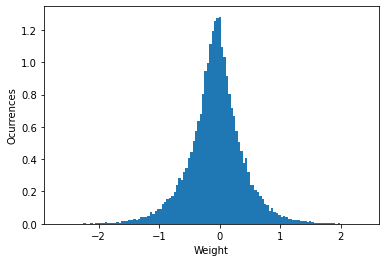

In [ ]:
vis_model(model_15)

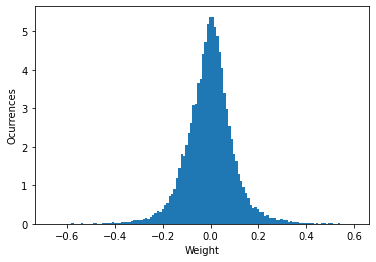

In [ ]:
vis_model(model_1)

So the weights of the model trained for 15 epochs are larger, may that be what is causing the problem?

We can see how weights are distributed in the Keras model and we will see the wights are smaller (more similar to the model trained for one epoch).

![](https://raw.githubusercontent.com/XanaGA/posts_en/cef7176a73aff834819bfb3c18735f8770ef2e0c/images/tf_weights.png)

The explanation may be that with larger weights the minimum and the maximum are further apart so the "resolution" of the quantization is worse. One quick fix could be **clamping** the weights, so they can not be larger or smaller than a certain threshold. But this will make that our model just learn in the few first iterations. It will produce a histogram like this one:

![](https://raw.githubusercontent.com/XanaGA/posts_en/4ed80f8f8e82cdcd59b177dc158135ae188547c9/images/clamp_weights.png)

A better option would be normalizing the weights so let's try it.


In [ ]:
model_15_norm, _ = train_model_and_quantize(epochs=15, norm_w=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
              ReLU-3           [-1, 32, 26, 26]               0
         MaxPool2d-4           [-1, 32, 13, 13]               0
            Conv2d-5           [-1, 64, 11, 11]          18,496
       BatchNorm2d-6           [-1, 64, 11, 11]             128
              ReLU-7           [-1, 64, 11, 11]               0
         MaxPool2d-8             [-1, 64, 5, 5]               0
           Flatten-9                 [-1, 1600]               0
          Dropout-10                 [-1, 1600]               0
           Linear-11                   [-1, 10]          16,010
Total params: 35,018
Trainable params: 35,018
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.44 s  -  Loss: 0.1988  -  Categorical_Accuracy: 0.9498  -  Val_Loss: 0.0593  -  Categorical_Val_Accuracy: 0.9806
Epoch 2


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.36 s  -  Loss: 0.0509  -  Categorical_Accuracy: 0.9848  -  Val_Loss: 0.0391  -  Categorical_Val_Accuracy: 0.9870
Epoch 3


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.51 s  -  Loss: 0.0383  -  Categorical_Accuracy: 0.9880  -  Val_Loss: 0.0392  -  Categorical_Val_Accuracy: 0.9871
Epoch 4


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.34 s  -  Loss: 0.0325  -  Categorical_Accuracy: 0.9901  -  Val_Loss: 0.0304  -  Categorical_Val_Accuracy: 0.9897
Epoch 5


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.37 s  -  Loss: 0.0279  -  Categorical_Accuracy: 0.9909  -  Val_Loss: 0.0394  -  Categorical_Val_Accuracy: 0.9877
Epoch 6


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.39 s  -  Loss: 0.0237  -  Categorical_Accuracy: 0.9928  -  Val_Loss: 0.0339  -  Categorical_Val_Accuracy: 0.9896
Epoch 7


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.33 s  -  Loss: 0.0208  -  Categorical_Accuracy: 0.9933  -  Val_Loss: 0.0284  -  Categorical_Val_Accuracy: 0.9899
Epoch 8


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.34 s  -  Loss: 0.0171  -  Categorical_Accuracy: 0.9948  -  Val_Loss: 0.0386  -  Categorical_Val_Accuracy: 0.9869
Epoch 9


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.35 s  -  Loss: 0.0154  -  Categorical_Accuracy: 0.9950  -  Val_Loss: 0.0476  -  Categorical_Val_Accuracy: 0.9849
Epoch 10


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.34 s  -  Loss: 0.0147  -  Categorical_Accuracy: 0.9952  -  Val_Loss: 0.0313  -  Categorical_Val_Accuracy: 0.9903
Epoch 11


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.34 s  -  Loss: 0.0116  -  Categorical_Accuracy: 0.9961  -  Val_Loss: 0.0375  -  Categorical_Val_Accuracy: 0.9885
Epoch 12


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.35 s  -  Loss: 0.0124  -  Categorical_Accuracy: 0.9960  -  Val_Loss: 0.0399  -  Categorical_Val_Accuracy: 0.9896
Epoch 13


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.34 s  -  Loss: 0.0099  -  Categorical_Accuracy: 0.9969  -  Val_Loss: 0.0283  -  Categorical_Val_Accuracy: 0.9918
Epoch 14


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.36 s  -  Loss: 0.0083  -  Categorical_Accuracy: 0.9973  -  Val_Loss: 0.0290  -  Categorical_Val_Accuracy: 0.9913
Epoch 15


  0%|          | 0/469 [00:00<?, ?it/s]

Time: 2.43 s  -  Loss: 0.0067  -  Categorical_Accuracy: 0.9977  -  Val_Loss: 0.0337  -  Categorical_Val_Accuracy: 0.9907
Finished Training
Running Final Evaluation
Model Name: mnist_model_float.pt, Quantized: False
Model Size: 142.11 KB
Accuracy: 0.9907
Eval time: 5.51s


/usr/local/lib/python3.7/dist-packages/torch/ao/quantization/observer.py:179: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."


Model Name: mnist_model_quantized.pt, Quantized: True
Model Size: 41.67 KB
Accuracy: 0.9838
Eval time: 6.13s


We get better results! Lower loss in performance while being able to reduce significantly the size of the model.

And as we can see the weights are now normalized.

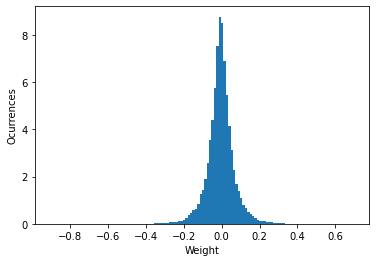

In [ ]:
vis_model(model_15_norm)

# Conclusion

After these experiments, the main takeaways would be the following:

* We can **look** at the network's weights and see what is happening. It is a good practice and provides some understanding of  how the model is being/has being trained.

* The values that our weight take are really important in quantization.

* We have to be careful with the weights not getting too large in our network. As we reward the outputs with higher values is feasible that the model tries to make its weights as big as possible.

* **Normalizing** the weight can lead to a better quantized models. Nevertheless, it can increase the training time with the same number of epochs. But it often converges faster, so fewer epochs are needed. You will have to study your problem carefully. No one said it was easy!